# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint 
from importlib import reload
import logging
logging.basicConfig(level=logging.ERROR)
import warnings
warnings.simplefilter("ignore")


import pandas as pd
import numpy as np
import xarray as xr
from sklearn.decomposition import PCA
import scipy.linalg as linalg

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator


from tools import utilityTools as utility
from tools import dataTools as dt
import pyaldata as pyal

%matplotlib inline
reload(dt)

root = pathlib.Path("/data")

# Compare different epochs

the idea is to see whether canonical axes between 2 animals provide a higher VAF for time epochs in the trial that they have not been trained on, compared to, for example, M1-PMd axes in a single animal.


## VAF in a subspace

Check the VAF for a single session as a test


In [2]:
animal= 'Chewie'
fname = root / animal / "Chewie_CO_CS_2016-10-21.mat"

df = pyal.mat2dataframe(fname, shift_idx_fields=True)

preprocessing

In [3]:
def get_target_id(trial):
    return int(np.round((trial.target_direction + np.pi) / (0.25*np.pi))) - 1

df = pyal.select_trials(df, df.result== 'R')
df = pyal.select_trials(df, df.epoch=='BL')
df = pyal.remove_low_firing_neurons(df, "M1_spikes", 1)
df = pyal.remove_low_firing_neurons(df, "PMd_spikes", 1)

df = pyal.add_firing_rates(df, 'smooth')

df["target_id"] = df.apply(get_target_id, axis=1)  # add a field `target_id` with int values

/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:940: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:940: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


applying PCA for 300ms post movement onset

In [4]:
df_ = pyal.restrict_to_interval(df, start_point_name='idx_movement_on', rel_start=0, rel_end=30)

M1_rates = np.concatenate(df_.M1_rates.values, axis=0)
M1_rates -=np.mean(M1_rates,axis=0)

M1_model = PCA(n_components=10, svd_solver='full');
M1_model.fit(M1_rates);
df_ = pyal.apply_dim_reduce_model(df_, M1_model, 'M1_rates', 'M1_pca');


PMd_rates = np.concatenate(df_.PMd_rates.values, axis=0)
PMd_rates -=np.mean(PMd_rates,axis=0)

PMd_model = PCA(n_components=10, svd_solver='full');
PMd_model.fit(PMd_rates);
df_ = pyal.apply_dim_reduce_model(df_, PMd_model, 'PMd_rates', 'PMd_pca');

to make life easy, just limit everything to 1 target

In [5]:
df__= pyal.select_trials(df_, df_.target_id ==4)

CCA on m1-pmd

In [6]:
d0 = np.concatenate(df__['M1_pca'].values, axis=0)
d1 = np.concatenate(df__['PMd_pca'].values, axis=0)

n_samples = min ([d0.shape[0], d1.shape[0]])
d0 = d0[:n_samples,:]
d1 = d1[:n_samples,:]

A, B, r, _, _ = dt.canoncorr(d0, d1, fullReturn=True)

In [7]:
print(f'the CCs are:{r}')

the CCs are:[8.96324810e-01 8.45333297e-01 6.09736330e-01 5.31759284e-01
 4.53251615e-01 3.78936008e-01 2.34072941e-01 1.31709437e-01
 7.19664795e-02 7.97605354e-04]


Based on the Gallego Nat Comm 2018 paper and some playing (data and projection matrices in the paper are row-wise): 
$$\%VAF=\frac{norm(X)-norm(X-XC^TA(A^TA)^{-1}A^TC)}{norm(X)}$$
where:
- $A$ is the CCA output, the output of the `canoncorr` function
- $C$ is the `PCA_model.components_`
- $X$ is the data matrix, $T\times n$ with $T$ time points and $n$ neurons, and each neuron is **zero mean**
- $norm$ is sum of squared elements  

In [8]:
C = M1_model.components_
X = M1_rates
norm = lambda m:np.sum(m**2)

VAF = norm(X) - norm(X-X@C.T@A@linalg.inv(A.T@A)@A.T@C)
VAF /= norm(X)

VAF

0.6482088310037387

Seems to give reasonable results: lowering number of PCs reduces the VAF.

However, there are problems:
- the formulation in the paper, gives a VAF for each dimension, so the formula above should be applied to individual axes.
- It is already implemented in MATLAB [here](https://github.com/limblab/proc-juan/blob/65dd81a1fc0ddb23def8039df9053a2be3e9bf88/paper_cross-task_manifold_review/vaf_CCs.m#L114), which uses the VAF function from the dPCA paper [here](https://github.com/machenslab/dPCA/blob/master/matlab/dpca_explainedVariance.m). I should translate that to compare?!?

> The value above actually equals to the total VAF :)

### dimension-wise VFA

In [9]:
D = linalg.inv(A.T@A)@A.T@C
E = C.T@A

VAFs=np.empty((C.shape[0],))

for comp in range(1,C.shape[0]+1):

    VAF = norm(X - X @ E[:,:comp] @ D[:comp,:]) / norm(X)
    VAFs[comp-1] = 1-VAF

VAFs = np.array([VAFs[0],*np.diff(VAFs)])
print(f'VAF for each axis: {VAFs} \n total: {sum(VAFs)}')

VAF for each axis: [0.02676476 0.10622462 0.00220823 0.09365388 0.07488183 0.08086034
 0.0431955  0.07888466 0.06745041 0.07408459] 
 total: 0.6482088310037387


In a concise function below:

In [10]:
print(dt.VAF_pc_cc(X,C,A))

[0.02676476 0.10622462 0.00220823 0.09365388 0.07488183 0.08086034
 0.0431955  0.07888466 0.06745041 0.07408459]


---

back to the original idea:

1. this:
> # Compare different epochs
> the idea is to see whether canonical axes between 2 animals provide a higher VAF for time epochs in the trial that they have not been trained on, compared to, for example, M1-PMd axes in a single animal.

2. and a similar but different idea:
> two monkeys during the same epoch vs. one monkey between 2 different epochs.
i.e., preparation vs execution, ...


#### Try the second idea first:

In [11]:
animalList = ['Chewie', 'Mihili']

animalFiles={}
for animal in animalList:
    animalFiles[animal] = utility.find_file(root / animal,'mat')

# just keeping the CS sessions
goodFiles = [file for animal in animalFiles for file in animalFiles[animal] if 'CS' in file]
pprint(goodFiles)

# keeping 1 session per animal
fileList = ['/data/Chewie/Chewie_CO_CS_2016-10-14.mat', '/data/Mihili/Mihili_CO_VR_2014-03-03.mat']

['/data/Chewie/Chewie_CO_CS_2016-10-14.mat',
 '/data/Chewie/Chewie_CO_CS_2016-10-21.mat',
 '/data/Mihili/Mihili_CO_CS_2015-05-12.mat',
 '/data/Mihili/Mihili_CO_CS_2014-09-29.mat',
 '/data/Mihili/Mihili_CO_CS_2015-05-11.mat',
 '/data/Mihili/Mihili_CO_CS_2014-06-26.mat',
 '/data/Mihili/Mihili_CO_CS_2014-06-27.mat',
 '/data/Mihili/Mihili_CO_CS_2014-12-03.mat']


In [45]:
df_data=[]
for fname in fileList:
    df = pyal.mat2dataframe(fname, shift_idx_fields=True)
    df_data.append(df)

preprocessing:

In [13]:
def prep_exec_all_targets (df, n_components=10):
    "preprocessing for execution eopch"
    df["target_id"] = df.apply(get_target_id, axis=1)  # add a field `target_id` with int values

    df_= pyal.add_firing_rates(df, 'smooth')
    
    df_= pyal.select_trials(df_, df_.result== 'R')
    df_= pyal.select_trials(df_, df_.epoch=='BL')
    
    df_ = pyal.remove_low_firing_neurons(df_, "M1_spikes", 1)
    df_ = pyal.remove_low_firing_neurons(df_, "PMd_spikes", 1)
    
    df_ = pyal.restrict_to_interval(df_, start_point_name='idx_movement_on', rel_start=0, rel_end=30)
    
    M1_rates = np.concatenate(df_.M1_rates.values, axis=0)
    pca_model = PCA(n_components=n_components, svd_solver='full');
    pca_model.fit(M1_rates);
    df_ = pyal.apply_dim_reduce_model(df_, pca_model, 'M1_rates', 'M1_pca');

    PMd_rates = np.concatenate(df_.PMd_rates.values, axis=0)
    pca_model = PCA(n_components=n_components, svd_solver='full');
    pca_model.fit(PMd_rates);
    df_ = pyal.apply_dim_reduce_model(df_, pca_model, 'PMd_rates', 'PMd_pca');

    
    return df_


df_data_exec = [prep_exec_all_targets(df) for  df in df_data]

/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:940: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:940: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:940: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:940: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


In [14]:
def prep_prep_all_targets (df, n_components=10):
    "preprocessing for Preparation epoch"
    df["target_id"] = df.apply(get_target_id, axis=1)  # add a field `target_id` with int values

    df_= pyal.add_firing_rates(df, 'smooth')
    
    df_= pyal.select_trials(df_, df_.result== 'R')
    df_= pyal.select_trials(df_, df_.epoch=='BL')
    
    df_ = pyal.remove_low_firing_neurons(df_, "M1_spikes", 1)
    df_ = pyal.remove_low_firing_neurons(df_, "PMd_spikes", 1)
    
    df_ = pyal.restrict_to_interval(df_, start_point_name='idx_movement_on', rel_start=-30, rel_end=0)
    
    M1_rates = np.concatenate(df_.M1_rates.values, axis=0)
    pca_model = PCA(n_components=n_components, svd_solver='full');
    pca_model.fit(M1_rates);
    df_ = pyal.apply_dim_reduce_model(df_, pca_model, 'M1_rates', 'M1_pca');

    PMd_rates = np.concatenate(df_.PMd_rates.values, axis=0)
    pca_model = PCA(n_components=n_components, svd_solver='full');
    pca_model.fit(PMd_rates);
    df_ = pyal.apply_dim_reduce_model(df_, pca_model, 'PMd_rates', 'PMd_pca');

    
    return df_


df_data_prep = [prep_prep_all_targets(df) for  df in df_data]

/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:940: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:940: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:940: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:940: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


plot

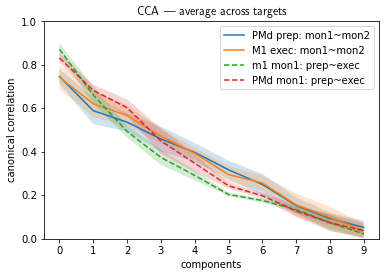

In [15]:
fig,ax = plt.subplots()

CC=[]
for target in range(8):
    dfs_prep = [pyal.select_trials(df_,df_.target_id==target) for df_ in df_data_prep]
    dfs_exec = [pyal.select_trials(df_,df_.target_id==target) for df_ in df_data_exec]
    
    # PMd prep: mon1~mon2
    CC.append(dt.CCA_pyal(dfs_prep[0],'PMd_pca', dfs_prep[1],'PMd_pca'))
    # M1 exec: mon1~mon2
    CC.append(dt.CCA_pyal(dfs_exec[0],'M1_pca', dfs_exec[1],'M1_pca'))
    # m1 mon1: prep~exec
    CC.append(dt.CCA_pyal(dfs_prep[0],'M1_pca', dfs_exec[0],'M1_pca'))
    # PMd mon1: prep~exec
    CC.append(dt.CCA_pyal(dfs_prep[0],'PMd_pca', dfs_exec[0],'PMd_pca'))

CC= np.array(CC)

utility.shaded_errorbar(ax,CC[0::8,:].T, label='PMd prep: mon1~mon2')
utility.shaded_errorbar(ax,CC[1::8,:].T, label='M1 exec: mon1~mon2')
utility.shaded_errorbar(ax,CC[2::8,:].T,ls='--',label='m1 mon1: prep~exec')
utility.shaded_errorbar(ax,CC[3::8,:].T,ls='--',label='PMd mon1: prep~exec')

ax.set_xlabel('components')
ax.set_ylabel('canonical correlation')
ax.legend()
ax.set_ylim([0,1])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('CCA --- average across targets', usetex=True);

similar results from prep~exec of Monkey2:

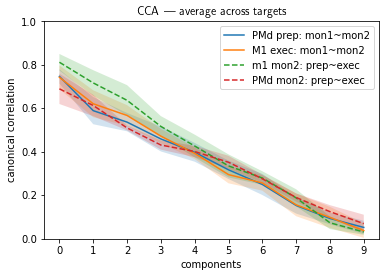

---

what about the VAF?  
I'll look at VAF, instead of correlation, in the plot above

In [72]:
def epoch_pyal (start_point_name: str =None, end_point_name: str =None, rel_start: int =0, rel_end: int =0):
    "Set the parameters for a time epoch"
    def restrict_to_interval(df: pd.DataFrame) -> pd.DataFrame:
        "Apply the interval (time epoch) to the Pyal DataFrame"
        return pyal.restrict_to_interval(df, start_point_name=start_point_name, end_point_name=end_point_name, rel_start=rel_start, rel_end=rel_end)
    return restrict_to_interval

In [66]:
def VAF_pc_cc_pyal(df1:pd.DataFrame, field1: str, epoch1, target1: int,
             df2:pd.DataFrame, field2: str, epoch2, target2: int) -> (np.ndarray, np.ndarray):
    """
    
    """
    if "target_id" not in df1.columns:
        df1["target_id"] = df1.apply(get_target_id, axis=1)
    if "target_id" not in df2.columns:
        df2["target_id"] = df2.apply(get_target_id, axis=1)
 
    df1 = epoch1(df1)
    rates_1 = np.concatenate(df1[field1].values, axis=0)
    rates_1 -= np.mean(rates_1,axis=0)
    rates_1_model = PCA(n_components=10, svd_solver='full').fit(rates_1)
    rates_1_C = rates_1_model.components_
    df1 = pyal.apply_dim_reduce_model(df1, rates_1_model, field1, '_pca');

    
    df1 = pyal.select_trials(df1, df1.target_id==target1)
    pca_1_target = np.concatenate(df1['_pca'].values, axis=0)

    
    df2 = epoch1(df2)
    rates_2 = np.concatenate(df2[field2].values, axis=0)
    rates_2 -= np.mean(rates_2,axis=0)
    rates_2_model = PCA(n_components=10, svd_solver='full').fit(rates_2)
    rates_2_C = rates_2_model.components_
    df2 = pyal.apply_dim_reduce_model(df2, rates_2_model, field2, '_pca');
    
    df2 = pyal.select_trials(df2, df2.target_id==target2)
    pca_2_target = np.concatenate(df2['_pca'].values, axis=0)
    
    
    # same number of timepoints in both matrices
    n_samples = min ([pca_1_target.shape[0], pca_2_target.shape[0]])
    pca_1_target = pca_1_target[:n_samples,:]
    pca_2_target = pca_2_target[:n_samples,:]

    A, B, _, _, _ = dt.canoncorr(pca_1_target, pca_2_target, fullReturn=True)
    VAFs1 = dt.VAF_pc_cc(rates_1, rates_1_C, A)
    VAFs2 = dt.VAF_pc_cc(rates_2, rates_2_C, B)
    
    return VAFs1, VAFs2


In [67]:
def prep_general (df, n_components=10):
    "preprocessing general!"
    df["target_id"] = df.apply(get_target_id, axis=1)  # add a field `target_id` with int values

    df_= pyal.add_firing_rates(df, 'smooth')
    
    df_= pyal.select_trials(df_, df_.result== 'R')
    df_= pyal.select_trials(df_, df_.epoch=='BL')
    
    df_ = pyal.remove_low_firing_neurons(df_, "M1_spikes", 1)
    df_ = pyal.remove_low_firing_neurons(df_, "PMd_spikes", 1)
    return df_


df_data_ready = [prep_general(df) for  df in df_data]

prep_epoch = epoch_pyal(start_point_name='idx_movement_on', rel_start=-30, rel_end=0)
exec_epoch = epoch_pyal(start_point_name='idx_movement_on', rel_start=0, rel_end=30)

/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:940: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:940: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:940: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:940: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


In [70]:
a,b = VAF_pc_cc_pyal(df1=df_data_ready[0], field1='M1_rates', epoch1=prep_epoch, target1=0,
               df2=df_data_ready[1], field2='M1_rates', epoch2=prep_epoch, target2=0)

In [71]:
sum(a),sum(b)

(0.6502203347968962, 0.704164975571471)

In [ ]:
fig,ax = plt.subplots()


CC=[]


# PMd prep: mon1~mon2
VAF_pc_cc_pyal()
CC.append(dt.CCA_pyal(dfs_prep[0],'PMd_pca', dfs_prep[1],'PMd_pca'))
# M1 exec: mon1~mon2
CC.append(dt.CCA_pyal(dfs_exec[0],'M1_pca', dfs_exec[1],'M1_pca'))
# m1 mon1: prep~exec
CC.append(dt.CCA_pyal(dfs_prep[0],'M1_pca', dfs_exec[0],'M1_pca'))
# PMd mon1: prep~exec
CC.append(dt.CCA_pyal(dfs_prep[0],'PMd_pca', dfs_exec[0],'PMd_pca'))

CC= np.array(CC)

utility.shaded_errorbar(ax,CC[0::8,:].T, label='PMd prep: mon1~mon2')
utility.shaded_errorbar(ax,CC[1::8,:].T, label='M1 exec: mon1~mon2')
utility.shaded_errorbar(ax,CC[2::8,:].T,ls='--',label='m1 mon1: prep~exec')
utility.shaded_errorbar(ax,CC[3::8,:].T,ls='--',label='PMd mon1: prep~exec')

ax.set_xlabel('components')
ax.set_ylabel('canonical correlation')
ax.legend()
ax.set_ylim([0,1])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('CCA --- average across targets', usetex=True);